In [1]:
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn
! pip install pycaret
! pip install imbalanced-learn
! pip install scikit-learn
! pip install openpyxl

In [2]:
import pandas as pd

In [3]:
dados = pd.read_csv('Sensor_FieldPRO.csv')

In [4]:
dados.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01T01:00:00Z,39.0,31.366,9419,0,44923,31
3,2020-10-01T02:00:00Z,39.0,31.322,9419,0,44825,31
4,2020-10-01T03:00:00Z,38.0,31.240,9416,0,44728,31


In [5]:
registro_chuvas = pd.read_csv('Estacao_Convencional.csv')

In [6]:
registro_chuvas.head()

,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.0
1,2020-09-01,01:00:00,0.0
2,2020-09-01,02:00:00,0.0
3,2020-09-01,03:00:00,0.0
4,2020-09-01,04:00:00,0.0


In [7]:
# Fatiar a coluna "Datetime – utc" em duas colunas separadas: data e hora, gerar uma nova coluna data na formatação de datetime
dados['data'] = dados['Datetime – utc'].str.slice(0, 10)
dados['hora'] = dados['Datetime – utc'].str.slice(11, 19)
dados['Datetime – utc'] = pd.to_datetime(dados['data'] + ' ' + dados['hora'], format='%Y-%m-%d %H:%M:%S')
dados.drop('data', axis=1, inplace=True)
dados.drop('hora', axis=1, inplace=True)

In [8]:
dados.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30 23:00:00,38.0,31.366,9412,0,45123,30
1,2020-10-01 00:00:00,NaN,NaN,9412,0,45025,31
2,2020-10-01 01:00:00,39.0,31.366,9419,0,44923,31
3,2020-10-01 02:00:00,39.0,31.322,9419,0,44825,31
4,2020-10-01 03:00:00,38.0,31.240,9416,0,44728,31


In [9]:
registro_chuvas['data'] = pd.to_datetime(registro_chuvas['data'] + ' ' + registro_chuvas['Hora (Brasília)'], format='%Y-%m-%d %H:%M:%S')

In [10]:
registro_chuvas.drop('Hora (Brasília)', axis=1, inplace=True)

In [11]:
registro_chuvas.head()

,data,chuva
0,2020-09-01 00:00:00,0.0
1,2020-09-01 01:00:00,0.0
2,2020-09-01 02:00:00,0.0
3,2020-09-01 03:00:00,0.0
4,2020-09-01 04:00:00,0.0


In [12]:
media_diaria_humidity = dados.groupby(dados['Datetime – utc'].dt.date)['air_humidity_100'].mean()
media_diaria_humidity_dict = media_diaria_humidity.to_dict()
dados['air_humidity_100'] = dados['air_humidity_100'].fillna(dados['Datetime – utc'].dt.date.map(media_diaria_humidity_dict))

media_diaria_temperature = dados.groupby(dados['Datetime – utc'].dt.date)['air_temperature_100'].mean()
media_diaria_temperature_dict = media_diaria_temperature.to_dict()
dados['air_temperature_100'] = dados['air_temperature_100'].fillna(dados['Datetime – utc'].dt.date.map(media_diaria_temperature_dict))

In [13]:
dados_merged = dados.merge(registro_chuvas, left_on='Datetime – utc', right_on='data', how='left')
dados_merged = dados_merged.sort_values(by='Datetime – utc', ascending=True)

In [14]:
dados_chuva_nao_zero = dados_merged[dados_merged['chuva'] > 0].copy()
dados_chuva_zero = dados_merged[dados_merged['chuva'] == 0].copy()

In [15]:
# Função para fazer o resample dos dados com base no piezo_charge
def resample_data(df):
    resampled_rows = []
    for i in range(1, len(df)):
        num_samples = 30  # Número de amostras a serem geradas entre duas linhas
        for j in range(num_samples + 1):
            new_row = df.iloc[i - 1].copy()
            new_row['Datetime – utc'] = df.iloc[i - 1]['Datetime – utc'] + pd.Timedelta(seconds=j * (df.iloc[i]['Datetime – utc'] - df.iloc[i - 1]['Datetime – utc']).seconds / num_samples)
            new_row['piezo_charge'] = df.iloc[i - 1]['piezo_charge'] + j * (df.iloc[i]['piezo_charge'] - df.iloc[i - 1]['piezo_charge']) / num_samples
            resampled_rows.append(new_row)

    resampled_df = pd.DataFrame(resampled_rows)
    return resampled_df

# Resample dos dados com "chuva" diferente de zero
dados_resampled_nao_zero = resample_data(dados_chuva_nao_zero)

In [16]:
len(dados_resampled_nao_zero)

1674

In [17]:
len(dados_chuva_zero)

1473

In [18]:
# Juntar os dois dataframes novamente
dados_combined_resampled = pd.concat([dados_resampled_nao_zero, dados_chuva_zero])
dados_combined_resampled = dados_combined_resampled.sort_values(by='Datetime – utc', ascending=True)
dados_combined_resampled.reset_index(drop=True, inplace=True)

In [19]:
dados_combined_resampled

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,data,chuva
0,2020-09-30 23:00:00,38.000000,31.366000,9412,0,45123.0,30,2020-09-30 23:00:00,0.0
1,2020-10-01 00:00:00,37.058824,31.846588,9412,0,45025.0,31,2020-10-01 00:00:00,0.0
2,2020-10-01 01:00:00,39.000000,31.366000,9419,0,44923.0,31,2020-10-01 01:00:00,0.0
3,2020-10-01 02:00:00,39.000000,31.322000,9419,0,44825.0,31,2020-10-01 02:00:00,0.0
4,2020-10-01 03:00:00,38.000000,31.240000,9416,0,44728.0,31,2020-10-01 03:00:00,0.0
...,...,...,...,...,...,...,...,...,...
3142,2020-12-03 19:00:00,86.000000,20.880000,9412,3,35217.0,20,2020-12-03 19:00:00,0.0
3143,2020-12-03 20:00:00,90.000000,20.980000,9409,3,35132.0,19,2020-12-03 20:00:00,0.0
3144,2020-12-03 21:00:00,93.000000,20.620000,9408,3,35068.0,20,2020-12-03 21:00:00,0.0
3145,2020-12-03 22:00:00,94.000000,20.080000,9406,3,35007.0,19,2020-12-03 22:00:00,0.0


In [20]:
dados_combined_resampled.drop('data', axis=1, inplace=True)

In [21]:
dados_combined_resampled.dropna(subset=['chuva'], inplace=True)
dados_combined_resampled.reset_index(drop=True,inplace=True)

In [22]:
dados_combined_resampled

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
0,2020-09-30 23:00:00,38.000000,31.366000,9412,0,45123.0,30,0.0
1,2020-10-01 00:00:00,37.058824,31.846588,9412,0,45025.0,31,0.0
2,2020-10-01 01:00:00,39.000000,31.366000,9419,0,44923.0,31,0.0
3,2020-10-01 02:00:00,39.000000,31.322000,9419,0,44825.0,31,0.0
4,2020-10-01 03:00:00,38.000000,31.240000,9416,0,44728.0,31,0.0
...,...,...,...,...,...,...,...,...
3142,2020-12-03 19:00:00,86.000000,20.880000,9412,3,35217.0,20,0.0
3143,2020-12-03 20:00:00,90.000000,20.980000,9409,3,35132.0,19,0.0
3144,2020-12-03 21:00:00,93.000000,20.620000,9408,3,35068.0,20,0.0
3145,2020-12-03 22:00:00,94.000000,20.080000,9406,3,35007.0,19,0.0


In [23]:
dados_combined_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime – utc       3147 non-null   datetime64[ns]
 1   air_humidity_100     3147 non-null   float64       
 2   air_temperature_100  3147 non-null   float64       
 3   atm_pressure_main    3147 non-null   int64         
 4   num_of_resets        3147 non-null   int64         
 5   piezo_charge         3147 non-null   float64       
 6   piezo_temperature    3147 non-null   int64         
 7   chuva                3147 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 196.8 KB


In [24]:
print(len(dados_combined_resampled[dados_combined_resampled['chuva'] > 0].copy()))
print(len(dados_combined_resampled[dados_combined_resampled['chuva'] == 0].copy()))

1674
1473


In [25]:
dados_combined_resampled

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
0,2020-09-30 23:00:00,38.000000,31.366000,9412,0,45123.0,30,0.0
1,2020-10-01 00:00:00,37.058824,31.846588,9412,0,45025.0,31,0.0
2,2020-10-01 01:00:00,39.000000,31.366000,9419,0,44923.0,31,0.0
3,2020-10-01 02:00:00,39.000000,31.322000,9419,0,44825.0,31,0.0
4,2020-10-01 03:00:00,38.000000,31.240000,9416,0,44728.0,31,0.0
...,...,...,...,...,...,...,...,...
3142,2020-12-03 19:00:00,86.000000,20.880000,9412,3,35217.0,20,0.0
3143,2020-12-03 20:00:00,90.000000,20.980000,9409,3,35132.0,19,0.0
3144,2020-12-03 21:00:00,93.000000,20.620000,9408,3,35068.0,20,0.0
3145,2020-12-03 22:00:00,94.000000,20.080000,9406,3,35007.0,19,0.0


In [26]:
dados_combined_resampled['Variação'] = dados_combined_resampled['piezo_charge'].diff()

In [27]:
# Criar uma lista para armazenar os índices das linhas que serão removidas
indices_a_remover = []

# Loop para percorrer o DataFrame e identificar as linhas com viradas em "num_of_resets"
for i in range(1, len(dados_combined_resampled)):
    if dados_combined_resampled.loc[i, "num_of_resets"] != dados_combined_resampled.loc[i - 1, "num_of_resets"]:
        indices_a_remover.append(i)

# Remover as linhas com viradas em "num_of_resets"
dados_combined_resampled.drop(indices_a_remover, inplace=True)

In [28]:
dados_combined_resampled.reset_index(drop=True,inplace=True)

In [29]:
dados_combined_resampled

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva,Variação
0,2020-09-30 23:00:00,38.000000,31.366000,9412,0,45123.0,30,0.0,NaN
1,2020-10-01 00:00:00,37.058824,31.846588,9412,0,45025.0,31,0.0,-98.0
2,2020-10-01 01:00:00,39.000000,31.366000,9419,0,44923.0,31,0.0,-102.0
3,2020-10-01 02:00:00,39.000000,31.322000,9419,0,44825.0,31,0.0,-98.0
4,2020-10-01 03:00:00,38.000000,31.240000,9416,0,44728.0,31,0.0,-97.0
...,...,...,...,...,...,...,...,...,...
3139,2020-12-03 19:00:00,86.000000,20.880000,9412,3,35217.0,20,0.0,-70.0
3140,2020-12-03 20:00:00,90.000000,20.980000,9409,3,35132.0,19,0.0,-85.0
3141,2020-12-03 21:00:00,93.000000,20.620000,9408,3,35068.0,20,0.0,-64.0
3142,2020-12-03 22:00:00,94.000000,20.080000,9406,3,35007.0,19,0.0,-61.0


In [30]:
mask = dados_combined_resampled['Variação'] <= 0
dados_combined_resampled = dados_combined_resampled[mask]

In [31]:
dados_combined_resampled.reset_index(drop=True,inplace=True)
dados_combined_resampled['Variação'] = dados_combined_resampled['Variação'] * -1

C:\Users\jfvie\AppData\Local\Temp\ipykernel_2812\2699261013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_combined_resampled['Variação'] = dados_combined_resampled['Variação'] * -1


In [32]:
dados_combined_resampled

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva,Variação
0,2020-10-01 00:00:00,37.058824,31.846588,9412,0,45025.0,31,0.0,98.0
1,2020-10-01 01:00:00,39.000000,31.366000,9419,0,44923.0,31,0.0,102.0
2,2020-10-01 02:00:00,39.000000,31.322000,9419,0,44825.0,31,0.0,98.0
3,2020-10-01 03:00:00,38.000000,31.240000,9416,0,44728.0,31,0.0,97.0
4,2020-10-01 04:00:00,39.000000,30.828000,9411,0,44632.0,30,0.0,96.0
...,...,...,...,...,...,...,...,...,...
2900,2020-12-03 19:00:00,86.000000,20.880000,9412,3,35217.0,20,0.0,70.0
2901,2020-12-03 20:00:00,90.000000,20.980000,9409,3,35132.0,19,0.0,85.0
2902,2020-12-03 21:00:00,93.000000,20.620000,9408,3,35068.0,20,0.0,64.0
2903,2020-12-03 22:00:00,94.000000,20.080000,9406,3,35007.0,19,0.0,61.0


In [33]:
dados_combined_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime – utc       2905 non-null   datetime64[ns]
 1   air_humidity_100     2905 non-null   float64       
 2   air_temperature_100  2905 non-null   float64       
 3   atm_pressure_main    2905 non-null   int64         
 4   num_of_resets        2905 non-null   int64         
 5   piezo_charge         2905 non-null   float64       
 6   piezo_temperature    2905 non-null   int64         
 7   chuva                2905 non-null   float64       
 8   Variação             2905 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 204.4 KB


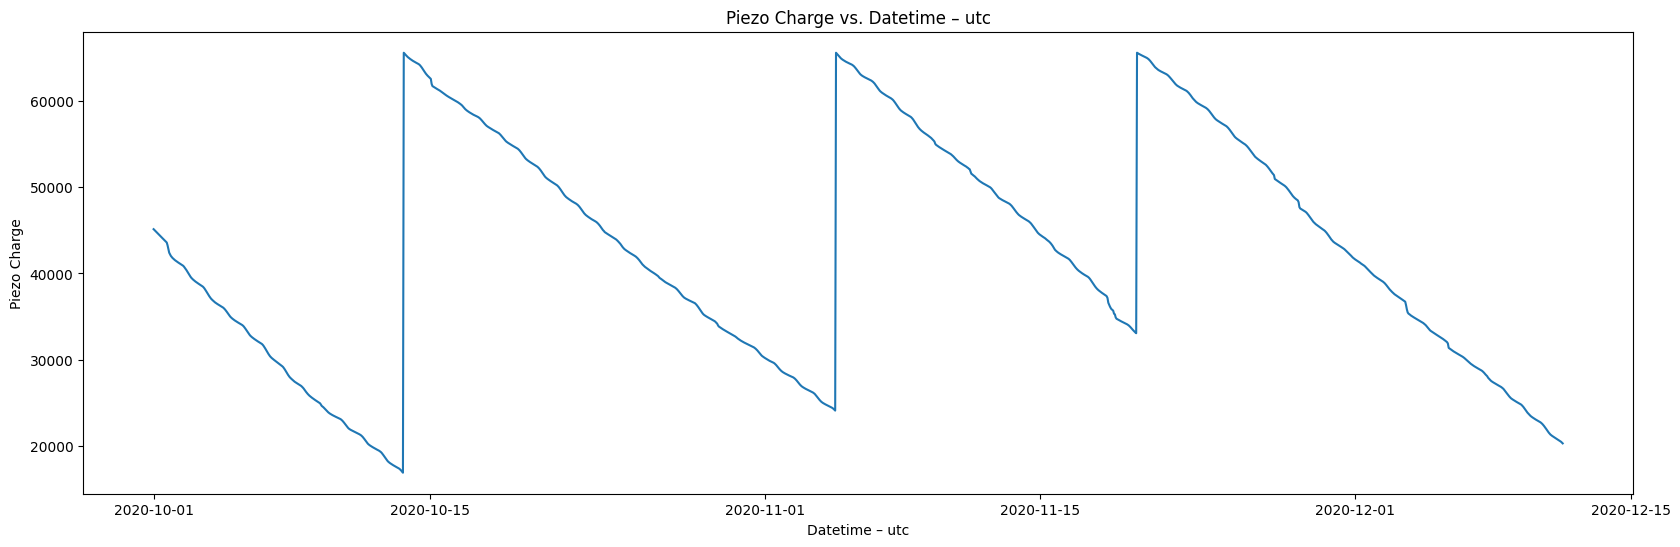

In [34]:
import matplotlib.pyplot as plt

# Plot do gráfico de linha
plt.figure(figsize=(20, 6))
plt.plot(dados_merged['Datetime – utc'],dados_merged['piezo_charge'])
# Configurações do gráfico
plt.xlabel('Datetime – utc')
plt.ylabel('Piezo Charge')
plt.title('Piezo Charge vs. Datetime – utc')

# Exibir o gráfico
plt.show()

In [35]:
dados_combined_resampled

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva,Variação
0,2020-10-01 00:00:00,37.058824,31.846588,9412,0,45025.0,31,0.0,98.0
1,2020-10-01 01:00:00,39.000000,31.366000,9419,0,44923.0,31,0.0,102.0
2,2020-10-01 02:00:00,39.000000,31.322000,9419,0,44825.0,31,0.0,98.0
3,2020-10-01 03:00:00,38.000000,31.240000,9416,0,44728.0,31,0.0,97.0
4,2020-10-01 04:00:00,39.000000,30.828000,9411,0,44632.0,30,0.0,96.0
...,...,...,...,...,...,...,...,...,...
2900,2020-12-03 19:00:00,86.000000,20.880000,9412,3,35217.0,20,0.0,70.0
2901,2020-12-03 20:00:00,90.000000,20.980000,9409,3,35132.0,19,0.0,85.0
2902,2020-12-03 21:00:00,93.000000,20.620000,9408,3,35068.0,20,0.0,64.0
2903,2020-12-03 22:00:00,94.000000,20.080000,9406,3,35007.0,19,0.0,61.0


In [36]:
dados_combined_resampled.drop('num_of_resets', axis=1, inplace=True)
dados_combined_resampled.drop(['piezo_charge'], axis=1, inplace=True)

C:\Users\jfvie\AppData\Local\Temp\ipykernel_2812\3192507343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_combined_resampled.drop('num_of_resets', axis=1, inplace=True)
C:\Users\jfvie\AppData\Local\Temp\ipykernel_2812\3192507343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_combined_resampled.drop(['piezo_charge'], axis=1, inplace=True)


In [37]:
dados_combined_resampled

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_temperature,chuva,Variação
0,2020-10-01 00:00:00,37.058824,31.846588,9412,31,0.0,98.0
1,2020-10-01 01:00:00,39.000000,31.366000,9419,31,0.0,102.0
2,2020-10-01 02:00:00,39.000000,31.322000,9419,31,0.0,98.0
3,2020-10-01 03:00:00,38.000000,31.240000,9416,31,0.0,97.0
4,2020-10-01 04:00:00,39.000000,30.828000,9411,30,0.0,96.0
...,...,...,...,...,...,...,...
2900,2020-12-03 19:00:00,86.000000,20.880000,9412,20,0.0,70.0
2901,2020-12-03 20:00:00,90.000000,20.980000,9409,19,0.0,85.0
2902,2020-12-03 21:00:00,93.000000,20.620000,9408,20,0.0,64.0
2903,2020-12-03 22:00:00,94.000000,20.080000,9406,19,0.0,61.0


In [38]:
dados_combined_resampled.reset_index(drop=True,inplace=True)

In [39]:
dados_combined_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime – utc       2905 non-null   datetime64[ns]
 1   air_humidity_100     2905 non-null   float64       
 2   air_temperature_100  2905 non-null   float64       
 3   atm_pressure_main    2905 non-null   int64         
 4   piezo_temperature    2905 non-null   int64         
 5   chuva                2905 non-null   float64       
 6   Variação             2905 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 159.0 KB


In [40]:
# Visualizar as primeiras linhas do DataFrame
dados_combined_resampled.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_temperature,chuva,Variação
0,2020-10-01 00:00:00,37.058824,31.846588,9412,31,0.0,98.0
1,2020-10-01 01:00:00,39.000000,31.366000,9419,31,0.0,102.0
2,2020-10-01 02:00:00,39.000000,31.322000,9419,31,0.0,98.0
3,2020-10-01 03:00:00,38.000000,31.240000,9416,31,0.0,97.0
4,2020-10-01 04:00:00,39.000000,30.828000,9411,30,0.0,96.0


In [41]:
# Verificar informações sobre as colunas e valores ausentes
dados_combined_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime – utc       2905 non-null   datetime64[ns]
 1   air_humidity_100     2905 non-null   float64       
 2   air_temperature_100  2905 non-null   float64       
 3   atm_pressure_main    2905 non-null   int64         
 4   piezo_temperature    2905 non-null   int64         
 5   chuva                2905 non-null   float64       
 6   Variação             2905 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 159.0 KB


In [42]:
# Sumarizar estatísticas descritivas dos dados numéricos
dados_combined_resampled.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_temperature,chuva,Variação
count,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000
mean,66.737516,23.576018,9426.857143,23.555250,1.497349,425.120929
std,22.578255,5.691334,28.428065,7.550185,3.011374,2503.839526
min,13.000000,12.360000,9350.000000,11.000000,0.000000,-0.000000
25%,49.000000,19.460000,9409.000000,18.000000,0.000000,4.666667
50%,71.000000,21.220000,9429.000000,20.000000,0.200000,54.000000
75%,87.000000,27.200000,9445.000000,28.000000,1.600000,96.000000
max,98.000000,42.664000,9507.000000,47.000000,16.800000,40776.000000


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

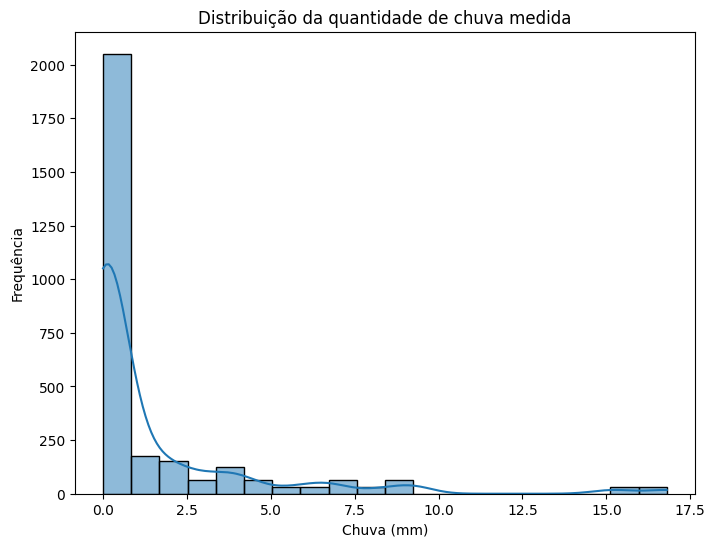

In [44]:
# Visualizar a distribuição da quantidade de chuva medida pela estação meteorológica convencional
plt.figure(figsize=(8, 6))
sns.histplot(data=dados_combined_resampled, x='chuva', bins=20, kde=True)
plt.title('Distribuição da quantidade de chuva medida')
plt.xlabel('Chuva (mm)')
plt.ylabel('Frequência')
plt.show()

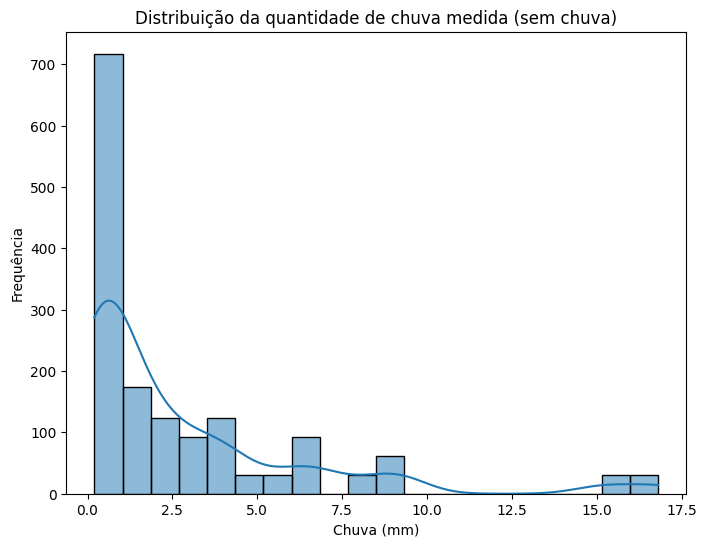

In [45]:
# Visualizar a distribuição da quantidade de chuva medida pela estação meteorológica convencional
plt.figure(figsize=(8, 6))
sns.histplot(data=dados_combined_resampled[dados_combined_resampled['chuva']>0].reset_index(drop=True),
              x='chuva', bins=20, kde=True)
plt.title('Distribuição da quantidade de chuva medida (sem chuva)')
plt.xlabel('Chuva (mm)')
plt.ylabel('Frequência')
plt.show()

In [46]:
dados_combined_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime – utc       2905 non-null   datetime64[ns]
 1   air_humidity_100     2905 non-null   float64       
 2   air_temperature_100  2905 non-null   float64       
 3   atm_pressure_main    2905 non-null   int64         
 4   piezo_temperature    2905 non-null   int64         
 5   chuva                2905 non-null   float64       
 6   Variação             2905 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 159.0 KB


C:\Users\jfvie\AppData\Local\Temp\ipykernel_2812\1623493750.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dados_combined_resampled.corr()


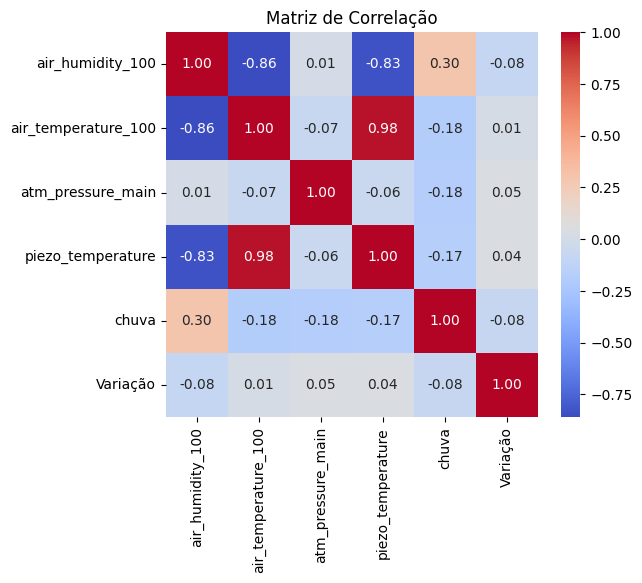

In [47]:
# Verificar a correlação entre as variáveis numéricas
correlation_matrix = dados_combined_resampled.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

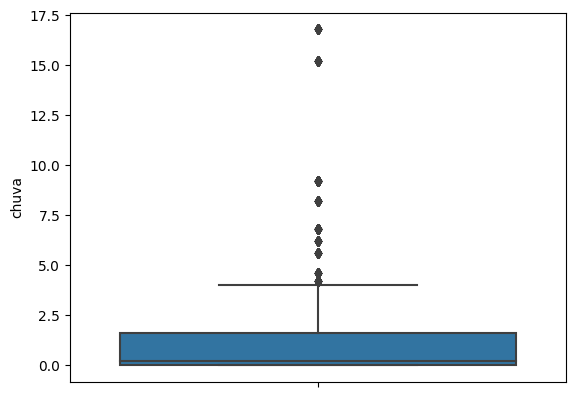

In [48]:
# Verificar a distribuição da variável alvo (chuva)
sns.boxplot(data=dados_combined_resampled, y='chuva')
plt.show()

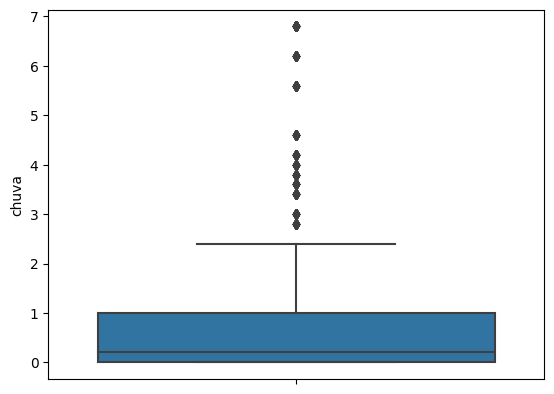

In [49]:
# # Filtrar e dropar registros de chuva com valor acima de 7.5
dados_sem_outliers = dados_combined_resampled[(dados_combined_resampled['chuva'] <= 7.5)].copy()
dados_sem_outliers.reset_index(drop=True,inplace=True)

# Verificar a distribuição atual da variável alvo (chuva)
sns.boxplot(data=dados_sem_outliers, y='chuva')
plt.show()

In [50]:
dados_combined_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime – utc       2905 non-null   datetime64[ns]
 1   air_humidity_100     2905 non-null   float64       
 2   air_temperature_100  2905 non-null   float64       
 3   atm_pressure_main    2905 non-null   int64         
 4   piezo_temperature    2905 non-null   int64         
 5   chuva                2905 non-null   float64       
 6   Variação             2905 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 159.0 KB


C:\Users\jfvie\AppData\Local\Temp\ipykernel_2812\1623493750.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dados_combined_resampled.corr()


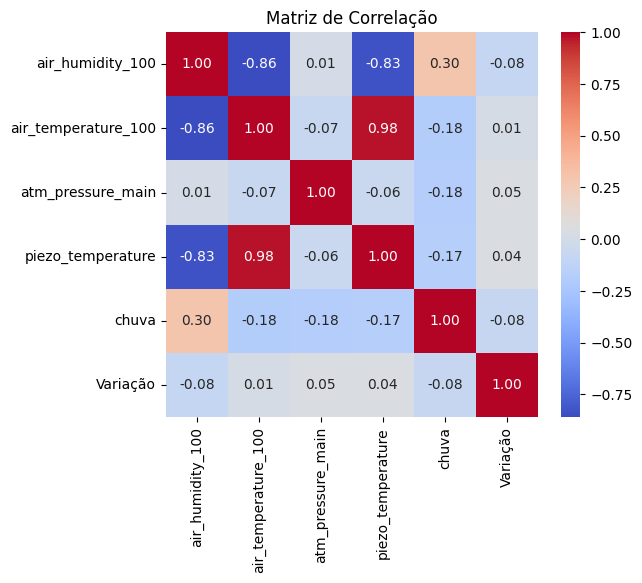

In [51]:
# Verificar a correlação entre as variáveis numéricas
correlation_matrix = dados_combined_resampled.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

C:\Users\jfvie\AppData\Local\Temp\ipykernel_2812\4018612146.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dados_sem_outliers.corr()


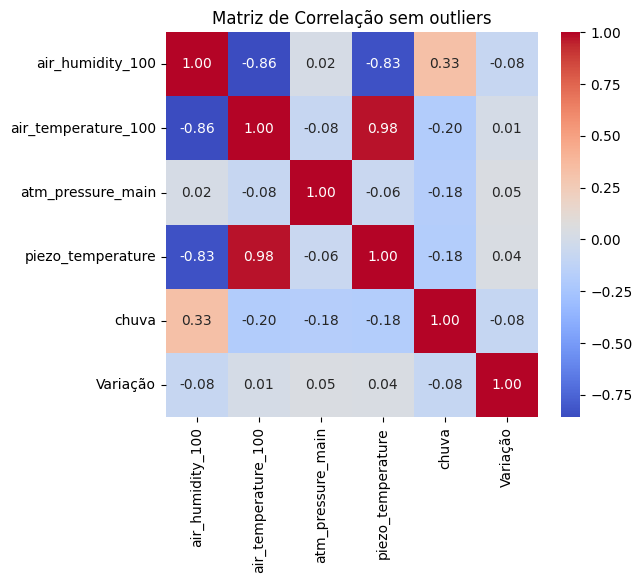

In [52]:
# Verificar a correlação entre as variáveis numéricas
correlation_matrix = dados_sem_outliers.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação sem outliers')
plt.show()

In [53]:
dados_sem_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime – utc       2750 non-null   datetime64[ns]
 1   air_humidity_100     2750 non-null   float64       
 2   air_temperature_100  2750 non-null   float64       
 3   atm_pressure_main    2750 non-null   int64         
 4   piezo_temperature    2750 non-null   int64         
 5   chuva                2750 non-null   float64       
 6   Variação             2750 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 150.5 KB


In [54]:
dados_combined_resampled.drop('Datetime – utc', axis=1, inplace=True)

C:\Users\jfvie\AppData\Local\Temp\ipykernel_2812\2400617016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_combined_resampled.drop('Datetime – utc', axis=1, inplace=True)


In [55]:
from pycaret.regression import *

In [56]:
dados_combined_resampled

,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_temperature,chuva,Variação
0,37.058824,31.846588,9412,31,0.0,98.0
1,39.000000,31.366000,9419,31,0.0,102.0
2,39.000000,31.322000,9419,31,0.0,98.0
3,38.000000,31.240000,9416,31,0.0,97.0
4,39.000000,30.828000,9411,30,0.0,96.0
...,...,...,...,...,...,...
2900,86.000000,20.880000,9412,20,0.0,70.0
2901,90.000000,20.980000,9409,19,0.0,85.0
2902,93.000000,20.620000,9408,20,0.0,64.0
2903,94.000000,20.080000,9406,19,0.0,61.0


In [57]:
dados_sem_outliers.columns

Index(['Datetime – utc', 'air_humidity_100', 'air_temperature_100',
       'atm_pressure_main', 'piezo_temperature', 'chuva', 'Variação'],
      dtype='object')

In [58]:
len(dados_sem_outliers.columns)

7

In [59]:
# Configurar o ambiente do PyCaret/
exp_reg = setup(dados_sem_outliers, target='chuva',session_id=123,fold=10,
                normalize=True,normalize_method = 'minmax', #minmax é útil quando queremos manter as proporções originais dos dados e quando eles não seguem uma distribuição normal.
                polynomial_features=True,polynomial_degree=5,
                remove_outliers = True, outliers_method = 'iforest',
                fold_strategy = 'timeseries'
                )

,Description,Value
0,Session id,123
1,Target,chuva
2,Target type,Regression
3,Original data shape,"(2750, 7)"
4,Transformed data shape,"(2653, 1287)"
5,Transformed train set shape,"(1827, 1287)"
6,Transformed test set shape,"(826, 1287)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


In [60]:
# Comparar o desempenho de vários modelos
best_model = compare_models(
                                # exclude=['lar',
                                #     'llar'
                                #     'en',
                                #     'lasso',
                                #     'dummy',
                                #     'par',
                                #     'huber',
                                #     'ridge',
                                #     'br',
                                #     'omp',
                                #     'lr'],
                            sort='R2',
                            verbose=True)
#Com um R² alto, podemos confiar mais nas previsões e estimativas feitas pelo modelo.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0735,0.0907,0.2915,0.9634,0.1514,0.1345,0.4370
xgboost,Extreme Gradient Boosting,0.0747,0.1094,0.3097,0.9540,0.1510,0.1350,0.5090
gbr,Gradient Boosting Regressor,0.1241,0.1128,0.3190,0.9518,0.1654,0.2396,0.4480
lightgbm,Light Gradient Boosting Machine,0.1060,0.1171,0.3276,0.9515,0.1545,0.1784,0.4860
rf,Random Forest Regressor,0.1072,0.1290,0.3402,0.9437,0.1681,0.2325,0.4580
ada,AdaBoost Regressor,0.3671,0.2357,0.4820,0.9052,0.2546,0.7171,0.4590
dt,Decision Tree Regressor,0.0836,0.2218,0.3890,0.8879,0.1704,0.1571,0.4550
knn,K Neighbors Regressor,0.2002,0.3597,0.5430,0.8286,0.2573,0.3934,0.4470
llar,Lasso Least Angle Regression,1.1926,2.7368,1.6411,-0.0150,0.6505,1.3784,0.4740
en,Elastic Net,1.1926,2.7368,1.6411,-0.0150,0.6505,1.3784,0.4300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

#### Utilizamos o PyCaret para treinar vários modelos de regressão e selecionamos o modelo de melhor desempenho. O modelo selecionado foi o Extra Trees Regressor, que apresentou os seguintes resultados:

#### **MAE (Mean Absolute Error)-Valor obtido = 0.0735 :**

##### O MAE é a média das diferenças absolutas entre as previsões do modelo e os valores reais. Ele mede a média do erro absoluto do modelo, ou seja, o quão distante as previsões estão dos valores reais. Quanto menor o valor do MAE, melhor, pois indica que o modelo tem previsões mais precisas em média.

#### **MSE (Mean Squared Error)-Valor obtido = 0.0907:**

##### O MSE é a média dos erros quadrados entre as previsões do modelo e os valores reais. Ele penaliza mais os erros maiores, tornando-o mais sensível a outliers. Quanto menor o valor do MSE, melhor, pois indica que o modelo tem previsões mais precisas em média.

#### **RMSE (Root Mean Squared Error)-Valor obtido = 0.2915:**

##### O RMSE é a raiz quadrada do MSE e representa a média dos erros quadrados em unidades originais. Ele fornece uma interpretação mais intuitiva do erro médio do modelo. Quanto menor o valor do RMSE, melhor, pois indica que o modelo tem previsões mais precisas em média.

#### **R² (Coefficient of Determination)-Valor obtido = 0.9634:**

##### O R² mede a proporção da variância total dos dados que é explicada pelo modelo. Ele varia de 0 a 1 e quanto mais próximo de 1, melhor o modelo explica a variabilidade dos dados. Nesse caso, o valor alto de 0.9831 indica que o modelo está explicando cerca de 98.31% da variância total dos dados, o que é excelente.

#### **RMSLE (Root Mean Squared Logarithmic Error)-Valor obtido = 0.1514:**

##### O RMSLE é uma métrica que leva em consideração a diferença entre os logaritmos das previsões e os logaritmos dos valores reais. É útil quando os valores têm uma ampla gama de magnitudes. Quanto menor o valor do RMSLE, melhor, pois indica que o modelo tem previsões mais precisas em média em uma escala logarítmica.

#### **MAPE (Mean Absolute Percentage Error)-Valor obtido = 0.1345:**

##### O MAPE é a média dos erros percentuais absolutos entre as previsões do modelo e os valores reais. Ele mede a porcentagem média pela qual as previsões do modelo estão desviando dos valores reais. Quanto menor o valor do MAPE, melhor, pois indica que o modelo tem previsões mais precisas em média em termos percentuais.

In [61]:
model_selected = create_model('et', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0784,0.0713,0.2671,0.9527,0.1627,0.2344
1,0.0855,0.1171,0.3422,0.9582,0.1378,0.0964
2,0.0744,0.0827,0.2875,0.9719,0.1436,0.1286
3,0.0800,0.0891,0.2984,0.9659,0.1558,0.1435
4,0.0592,0.0811,0.2848,0.9678,0.1425,0.2715
5,0.0884,0.2062,0.4541,0.9204,0.1773,0.0732
6,0.0835,0.0619,0.2489,0.9858,0.1574,0.1066
7,0.0767,0.1239,0.3520,0.9366,0.1689,0.2094
8,0.0410,0.0263,0.1621,0.9908,0.1164,0.0294


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [62]:
# Ajustar automaticamente os hiperparâmetros do melhor modelo
tuned_model = tune_model(model_selected, optimize= "MAE",
                          fold=10,verbose=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2204,0.1598,0.3998,0.8939,0.2072,0.6590
1,0.1743,0.2264,0.4758,0.9191,0.1546,0.2358
2,0.2034,0.2471,0.4971,0.9159,0.1862,0.4449
3,0.1408,0.1020,0.3194,0.9610,0.1653,0.2924
4,0.1303,0.1132,0.3364,0.9551,0.1568,0.4547
5,0.1514,0.2267,0.4761,0.9125,0.1703,0.2412
6,0.1666,0.1097,0.3312,0.9749,0.1573,0.2878
7,0.1207,0.1181,0.3436,0.9396,0.1530,0.3528
8,0.1083,0.0309,0.1757,0.9892,0.1103,0.1645


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [63]:
# Avaliar o desempenho do modelo ajustado
evaluate_model(tuned_model, fold=10)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [64]:
# Fazer previsões com o modelo ajustado
df_predictions = predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0458,0.0831,0.2883,0.9650,0.1280,0.0613


In [65]:
df_predictions['prediction_label'] = df_predictions[['prediction_label']].round(1)

In [66]:
df_predictions

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_temperature,Variação,chuva,prediction_label
368,2020-10-12 05:00:00,68.0,17.514000,9450,17,54.000000,0.0,0.0
738,2020-10-23 17:36:00,33.0,35.200001,9427,40,4.666667,0.2,0.2
2066,2020-11-18 19:44:00,94.0,19.580000,9390,19,14.033334,2.2,2.2
252,2020-10-09 08:58:00,80.0,21.094000,9391,20,2.033333,1.2,1.2
556,2020-10-16 21:00:00,58.0,24.340000,9473,24,76.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
187,2020-10-07 20:00:00,24.0,38.405998,9397,41,139.000000,0.0,0.0
2094,2020-11-19 03:40:00,95.0,18.020000,9393,18,20.366667,0.2,0.2
797,2020-10-25 04:00:00,77.0,21.360001,9404,19,60.000000,0.0,0.0
2509,2020-11-30 13:00:00,68.0,25.360001,9467,28,90.000000,0.0,0.0


In [67]:
df_predictions['Erro_Percentual'] = ((df_predictions['chuva'] - df_predictions['prediction_label']) / df_predictions['chuva']) * 100

In [68]:
df_predictions['Erro_Percentual'].fillna(0, inplace=True)

In [69]:
df_predictions['Erro_Percentual'] = df_predictions[['Erro_Percentual']].round(2)

In [70]:
import numpy as np

In [71]:
df_predictions['Erro_Percentual'].replace([np.inf, -np.inf], 0, inplace=True)

In [72]:
df_predictions.to_excel('df_predictions.xlsx',index=False)

In [73]:
percentual_medio_erro = df_predictions['Erro_Percentual'].mean()

print("Percentual médio de erro : {:.2f}%".format(percentual_medio_erro))

Percentual médio de erro : -2.06%


In [74]:
# Filtrar as previsões onde a coluna "chuva" é diferente de 0
df_predictions_chuva_diferente_zero = df_predictions[df_predictions['chuva'] != 0]

# Calcular o percentual médio de erro
percentual_medio_erro = df_predictions_chuva_diferente_zero['Erro_Percentual'].mean()

print("Percentual médio de erro para chuva diferente de 0: {:.2f}%".format(percentual_medio_erro))


Percentual médio de erro para chuva diferente de 0: -4.16%


In [75]:
df_predictions_chuva_diferente_zero

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_temperature,Variação,chuva,prediction_label,Erro_Percentual
738,2020-10-23 17:36:00,33.0,35.200001,9427,40,4.666667,0.2,0.2,0.0
2066,2020-11-18 19:44:00,94.0,19.580000,9390,19,14.033334,2.2,2.2,0.0
252,2020-10-09 08:58:00,80.0,21.094000,9391,20,2.033333,1.2,1.2,0.0
2424,2020-11-28 02:44:00,73.0,22.480000,9468,22,6.900000,1.0,1.0,0.0
748,2020-10-23 17:56:00,33.0,35.200001,9427,40,4.666667,0.2,0.2,0.0
...,...,...,...,...,...,...,...,...,...
2060,2020-11-18 19:20:00,94.0,19.580000,9390,19,14.033334,2.2,2.2,0.0
236,2020-10-09 08:26:00,80.0,21.094000,9391,20,2.033333,1.2,1.2,0.0
1920,2020-11-18 14:08:00,92.0,19.760000,9411,19,4.600000,0.8,0.8,0.0
1827,2020-11-18 10:08:00,94.0,19.340000,9395,18,18.466667,4.2,4.2,-0.0


In [76]:
# Filtrar as previsões onde a coluna "chuva" é igual a 0
df_predictions_chuva_igual_zero = df_predictions[df_predictions['chuva'] == 0]

# Calcular o percentual médio de erro
percentual_medio_erro = df_predictions_chuva_igual_zero['Erro_Percentual'].mean()

print("Percentual médio de erro para chuva igual a 0: {:.2f}%".format(percentual_medio_erro))


Percentual médio de erro para chuva igual a 0: 0.00%


In [77]:
df_predictions_chuva_igual_zero

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,piezo_temperature,Variação,chuva,prediction_label,Erro_Percentual
368,2020-10-12 05:00:00,68.0,17.514000,9450,17,54.0,0.0,0.0,0.0
556,2020-10-16 21:00:00,58.0,24.340000,9473,24,76.0,0.0,0.0,0.0
2278,2020-11-26 15:00:00,33.0,35.779999,9442,38,128.0,0.0,0.0,0.0
119,2020-10-06 04:00:00,68.0,22.948000,9414,21,65.0,0.0,0.0,0.0
1290,2020-11-07 01:00:00,34.0,23.260000,9436,21,68.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
74,2020-10-04 07:00:00,75.0,19.167999,9440,18,57.0,0.0,0.0,0.0
187,2020-10-07 20:00:00,24.0,38.405998,9397,41,139.0,0.0,0.0,0.0
797,2020-10-25 04:00:00,77.0,21.360001,9404,19,60.0,0.0,0.0,0.0
2509,2020-11-30 13:00:00,68.0,25.360001,9467,28,90.0,0.0,0.0,0.0
